In [35]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torchvision.transforms import ToTensor
from torch import nn, optim
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
from transformers import ViTModel, ViTImageProcessor, ViTForImageClassification
from timm import create_model

from torch.utils.data.sampler import SubsetRandomSampler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
os.getcwd()
os.chdir('../..')
root_dir=os.getcwd()
root_dir

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio'

### CNN 

In [3]:
print("Root Project Path : ", root_dir)
ROOT_DATA_DIR = os.path.join(root_dir, 'data', 'xview_building_damage')
print("Root Data Path : ", ROOT_DATA_DIR)
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DATA_DIR)
CHALLENGE_DIR = os.path.join(ROOT_DATA_DIR, 'challenge')

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio
Root Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train


In [4]:
def get_device():
    device = 'cpu' 
    if torch.cuda.is_available(): 
     device='cuda'
    # elif torch.backends.mps.is_available():
    #  device = 'mps' 
    print(" Device Available ", device)
    return torch.device(device)

get_device()

 Device Available  cpu


device(type='cpu')

In [5]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)

### Load Data

In [6]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [7]:
def get_img_class_dir(disaster_name, dataSplit, ROOT_DIR):   
 DIR=os.path.join(ROOT_DIR, dataSplit,'disaster', disaster_name , 'class', 'post')
 return DIR

In [8]:
train_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'train', CHALLENGE_DIR), transform=data_transform)
valid_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'hold', CHALLENGE_DIR), transform=data_transform)
test_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'test', CHALLENGE_DIR), transform=data_transform)
#dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
print("Train set records : ", len(train_dataset))
print("Validation set records : ", len(valid_dataset))
print("Test set records : ", len(test_dataset))
print("================================================")
print(f"Train data:\n{train_dataset}")
print(f"Validation data:\n{valid_dataset}")
print(f"Test data:\n{test_dataset}")

Train set records :  22686
Validation set records :  7158
Test set records :  5657
Train data:
Dataset ImageFolder
    Number of datapoints: 22686
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/class/post
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 7158
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/class/post
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 5657
    Root location:

In [9]:
class_names = train_dataset.classes
class_names

['destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified']

In [10]:
class_dict = train_dataset.class_to_idx
class_dict

{'destroyed': 0,
 'major-damage': 1,
 'minor-damage': 2,
 'no-damage': 3,
 'un-classified': 4}

In [11]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [12]:
trainset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset))))
testset = torch.utils.data.Subset(test_dataset, list(range(len(test_dataset))))
validset = torch.utils.data.Subset(valid_dataset, list(range(len(valid_dataset))))

In [13]:
batch_size = 128

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(validset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=2)

### Visualization Helper

In [14]:
## This is adapted from https://www.kaggle.com/code/toygarr/pytorch-baseline-for-image-classification-tasks
def plot_training_metrics(train_hist, model, test_data, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_pred, pos_label=9)
    AUC       = metrics.auc(fpr, tpr)*100
    Acc       = accuracy_score(y_actual, y_pred)*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    loss_values     = [x.get("train_loss") for x in history]
    val_loss_values = [x["val_loss"] for x in history]
    val_acc_values  = [x["val_acc"] for x in history]    
   

    # get the min loss and max accuracy for plotting
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(loss_values, 'bo', label = 'Training loss')
    plt.plot(val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(val_acc_values, 'cornflowerblue', label = 'Validation Accuracy')
    plt.title('Validation Accuracy by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [15]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat((all_preds, preds) ,dim=0)

    return all_preds

In [16]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [17]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class CNN(BaseModel):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes, numChannels):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=numChannels, out_channels=32, kernel_size=5, padding='same')
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) 
    
        self.fc1 = nn.Linear( (224 * 224), 128)
        self.fc2 = nn.Linear(128, num_classes)
                
        self.relu1 = nn.ReLU()
        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout(0.5)

    
    # Progresses data across layers    
    def forward(self, x):
        #CNN Layer 1
        out = self.conv_layer1(x)
        out = self.relu1(out)
        
        #CNN Layer 2
        out = self.conv_layer2(out)
        out = self.relu1(out)
        out = self.max_pool1(out)
        #out = self.dropout(out)

        #CNN Layer 3
        out = self.conv_layer3(out)
        out = self.relu1(out)
        out = self.max_pool2(out)
        
        #CNN Layer 3
        out = self.conv_layer3(out)
        out = self.relu1(out)
        #out = self.dropout(out)
        
        #CNN Layer 4
        out = self.conv_layer4(out)
        out = self.relu1(out)
        
        #CNN Layer 5
        out = self.conv_layer5(out)
        out = self.relu1(out)
        out = self.max_pool2(out)

        #Out layers
        out = out.reshape(out.size(0), -1)
        #out = self.dropout(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [19]:
epochs = 10
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR
classes = tuple(class_names)
num_classes = len(classes)
num_classes

5

In [20]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_loader, device)
test_dl = ToDeviceLoader(test_loader, device)

 Device Available  cpu
cpu


In [21]:
model = CNN(num_classes, numChannels=3)
criterion = nn.CrossEntropyLoss()
total_step = len(train_loader)
model = to_device(model, device)

#### Training

In [22]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [23]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)

    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [24]:
trainSteps = len(train_loader.dataset) 
valSteps = len(valid_loader.dataset)
trainSteps, valSteps

(22686, 7158)

In [25]:
%%time
history = fit(epochs=epochs, train_dl=train_loader, test_dl=test_loader, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=scheduler)

Epoch [0], last_lr: 0.00028, train_loss: 10.5221, val_loss: 116.7131, val_acc: 0.6332
Epoch [1], last_lr: 0.00076, train_loss: 12.9323, val_loss: 36.6527, val_acc: 0.6332
Epoch [2], last_lr: 0.00100, train_loss: 9.6495, val_loss: 19.8845, val_acc: 0.6332
Epoch [3], last_lr: 0.00095, train_loss: 12.0541, val_loss: 44.4463, val_acc: 0.6332
Epoch [4], last_lr: 0.00081, train_loss: 2.4641, val_loss: 2.1174, val_acc: 0.6332
Epoch [5], last_lr: 0.00061, train_loss: 3.0740, val_loss: 3.4179, val_acc: 0.6332
Epoch [6], last_lr: 0.00039, train_loss: 1.1648, val_loss: 3.7679, val_acc: 0.6332
Epoch [7], last_lr: 0.00019, train_loss: 2.4554, val_loss: 1.5229, val_acc: 0.6332
Epoch [8], last_lr: 0.00005, train_loss: 1.5153, val_loss: 1.5112, val_acc: 0.6332
Epoch [9], last_lr: 0.00000, train_loss: 1.5087, val_loss: 1.5101, val_acc: 0.6332
CPU times: user 20h 45min 47s, sys: 2h 30min 17s, total: 23h 16min 4s
Wall time: 19h 15min 58s


### Plots

In [26]:
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

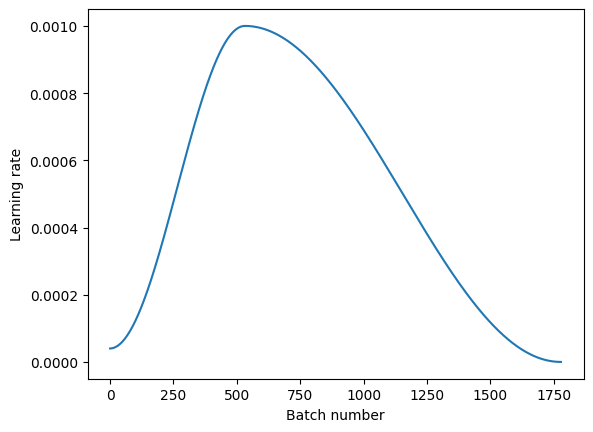

In [27]:
plot_lrs(history)

In [28]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [29]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: destroyed is 0.0 %
Accuracy for class: major-damage is 0.0 %
Accuracy for class: minor-damage is 0.0 %
Accuracy for class: no-damage is 100.0 %
Accuracy for class: un-classified is 0.0 %


In [30]:
def predict(model, test_loader, device):
    
    # set model to evaluate model
    model.eval()
    
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
    return y_true, y_pred, y_pred_prob

In [33]:
y_true, y_pred, y_pred_prob = predict(model, test_loader, device)

/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/sk


 Model AUC nan%, Accuracy 64.47% on Test Data

               precision    recall  f1-score   support

    destroyed       0.00      0.00      0.00       183
 major-damage       0.00      0.00      0.00       409
 minor-damage       0.00      0.00      0.00      1363
    no-damage       0.64      1.00      0.78      3647
un-classified       0.00      0.00      0.00        55

     accuracy                           0.64      5657
    macro avg       0.13      0.20      0.16      5657
 weighted avg       0.42      0.64      0.51      5657



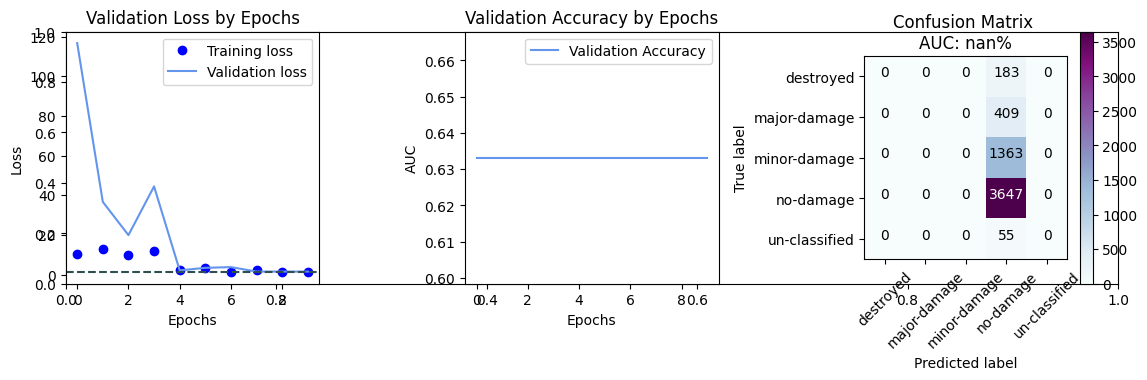

In [36]:
plot_training_metrics(history, model, test_dataset, y_true, y_pred, classes, model_name = "v2")

In [39]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_dataset.classes[preds[0].item()]

Label: destroyed , Predicted: no-damage


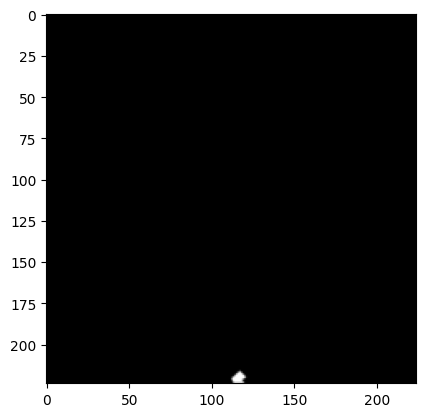

In [40]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: minor-damage , Predicted: no-damage


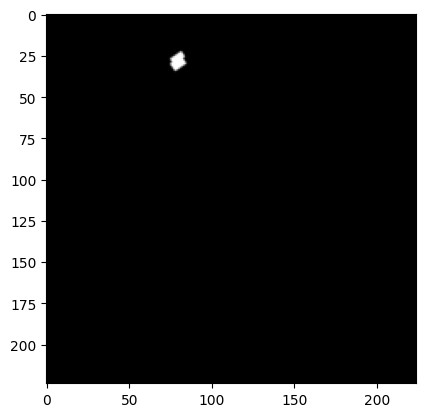

In [41]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

### Save

In [42]:
torch.save(model.state_dict(), 'build_damage_cnn_model.pth')

### Find Probability

In [43]:
def find_prob(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    yb = F.softmax(yb, dim=1).cpu().detach().numpy()
    return yb

In [45]:
n_samples = 100
random_index = int(np.random.random()*n_samples)
img, label = test_dataset[random_index]
y_query_prob = find_prob(img, model)
sorted_index = np.argsort(-1*y_query_prob)
print(f"Selected Query Image -> label_idx: {label}, label: {test_dataset.classes[label]}")
print("TOP 5 LABELS:")
for i in range(5):
    print(f"label_idx: {sorted_index[0][i]}, label: {test_dataset.classes[sorted_index[0][i]]}")

Selected Query Image -> label_idx: 0, label: destroyed
TOP 5 LABELS:
label_idx: 3, label: no-damage
label_idx: 2, label: minor-damage
label_idx: 1, label: major-damage
label_idx: 4, label: un-classified
label_idx: 0, label: destroyed
